In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json
import sys
sys.path.append("../../../")

from src.context_aware.config import ModelConfig, TrainingConfig, MetaConfig
from src.dataset_manager import DatasetConvertor 
from src.context_aware.preprocessing import PreprocessingDataset
from src.context_aware.models import createModel
from src.context_aware.training import trainModel
from src.context_aware.evaluation import evaluateModel

In [2]:
rawDatasetFolder = "../../../data/raw"
dpdrDatasetFolder = "../../../data/processed/dpdr"
configPath = "../../config/combined_flows_forward_50.json"
modelFolder = "../../../data/models/context_aware"
verbose = True

In [3]:
datasetConverter = DatasetConvertor(rawDatasetFolder, randomFlag=False)
with open(configPath, "r") as f:
    config = json.load(f)

name = config.get("NAME")
len_window = config.get("LEN_WINDOW")
dim_data = len(config.get("CONTEXT_IDXS"))
train_ratio = config.get("TRAIN_RATIO")

datasetConverter.addDataUnit(config)
dataUnit = datasetConverter.getDataUnit(name)
max_vals, min_vals = dataUnit.getMaxMinMbnVals()
metaConfig = MetaConfig.initialize(
    dim_data=dim_data, 
    window_length=len_window, 
    max_vals=max_vals, 
    min_vals=min_vals
)
modelConfig = ModelConfig.from_meta_config(metaConfig)
trainDataUnit, testDataUnit = dataUnit.split(train_ratio)

# =============== Save ===============
testDataUnit.saveDataUnit(f"{dpdrDatasetFolder}/{name}.csv")
with open(f"{modelFolder}/{name}_modelConfig.pkl", "wb") as f:
    pickle.dump(modelConfig, f)
with open(f"{modelFolder}/{name}_metaConfig.pkl", "wb") as f:
    pickle.dump(metaConfig, f)

In [25]:
# =============== Preprocessing ===============
dataProcessor = PreprocessingDataset(metaConfig)
trainData = dataProcessor.process(trainDataUnit, dataAugment=True, filterMode='filtfilt')
testData = dataProcessor.process(testDataUnit, dataAugment=False, filterMode='filtfilt')

# =============== Training ===============
model, device = createModel(modelConfig)
trainingConfig = TrainingConfig()
model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose, 
    model_path=f"{modelFolder}/{name}.pth"
)

Size of train loader: 9, Size of test loader: 1
Used device: cuda:0
Size of model: 108206
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=1326, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.8, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=50, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=114, out_features=1, bias=True)
    (trans2trafficClass_layer): Linear(in_features=114, out_features=51, bias=True)
  )
  (contextA

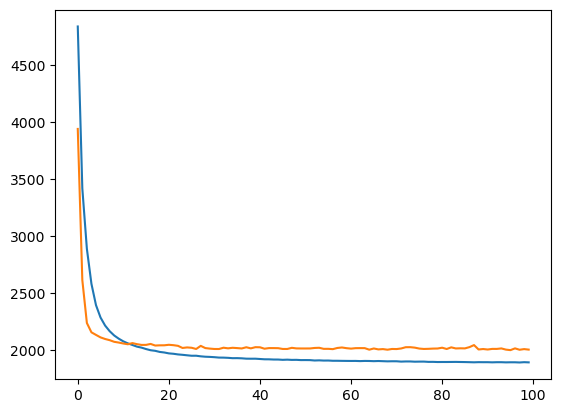

In [26]:
plt.plot(avg_train_loss_history)
plt.plot(avg_test_loss_history)
plt.show()

../../../data/models/context_aware/combined_flows_forward_40.pth
MSE: 18.764467239379883


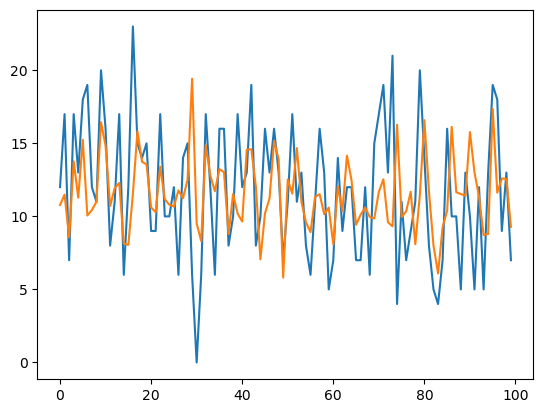

In [5]:
dataProcessor = PreprocessingDataset(metaConfig)
testData = dataProcessor.process(testDataUnit, dataAugment=False, filterMode='filtfilt')
with open(f"{modelFolder}/{name}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{modelFolder}/{name}.pth")
print(f"{modelFolder}/{name}.pth")
results = evaluateModel(model, testData)

mse = np.mean((results['trafficTarget_actual'] - results['trafficTarget_predicted']) ** 2)
print(f"MSE: {mse}")

plt.plot(results['trafficTarget_actual'][0:100])
plt.plot(results['trafficTarget_predicted'][0:100])
plt.show()